# DA5401: Assignment 4
#### MM21B051 - Preethi

In [55]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix

### Question 1
We define a Dummy Binary Classifier wich assigns True/False based on various distributions: uniform random, bernoulli, gaussian

In [56]:
class DummyBinaryClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='uniform_random'):
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["uniform_random", "bernoulli", "gaussian"] else "uniform_random"
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # we center the normal distribution at 0.5 instead of 0.0
        if self.method == "gaussian":
            return (0.5 + np.random.randn(len(X))) < self.p
        elif self.method == "bernoulli":
            return np.bool_(bernoulli.rvs(self.p, size=len(X)))
        else:
            return np.random.rand(len(X)) < self.p

In [57]:
# let's create a dataset of size 100 instances.
X = np.random.rand(100)

In [58]:
cla = DummyBinaryClassifier(p=0.3, method='gaussian')
y = cla.predict(X)
c = Counter(y) 
{i[0]: i[1] / len(y) for i in c.items()}

{np.True_: 0.38, np.False_: 0.62}

We see that giving a p vlaue of 0.3 gives a distribution with False values slightly more than True values as p<0.5

In [59]:
def compute_prior(y):
    # initialize the counter object on the 'y' labels
    c = Counter(y)
    # convert the labels into class proportions
    props = {i[0]:i[1]/len(y) for i in c.items()}
    if True not in props:
        props[True] = 0.0
    if False not in props:
        props[False] = 0.0
    return props

In [60]:
p_vals = np.arange(0., 1., 0.1)
b_vals = []
g_vals = []
u_vals = []
for p in p_vals:
    # spawn the DummyBinaryClassifier with bernouli random sample generator
    cla = DummyBinaryClassifier(p=p, method='bernoulli')
    # predict the labels for the input
    y = cla.predict(X)
    # compute priors
    props = compute_prior(y)
    # pick the probabilty of True class
    b_vals.append(props[True])
    
    # spawn the DummyBinaryClassifier with gaussian random sample generator
    y = DummyBinaryClassifier(p=p, method='gaussian').predict(X)
    g_vals.append(compute_prior(y)[True])
    
    # spawn the DummyBinaryClassifier with uniform random sample generator
    y = DummyBinaryClassifier(p=p, method='uniform_random').predict(X)
    u_vals.append(compute_prior(y)[True])

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
C:\Users\preet\AppData\Local\Temp\ipykernel_11812\128745719.py:7: SyntaxWarning: invalid escape sequence '\i'
  plt.title('Label proportion at different values of $p\in[0,1]$')


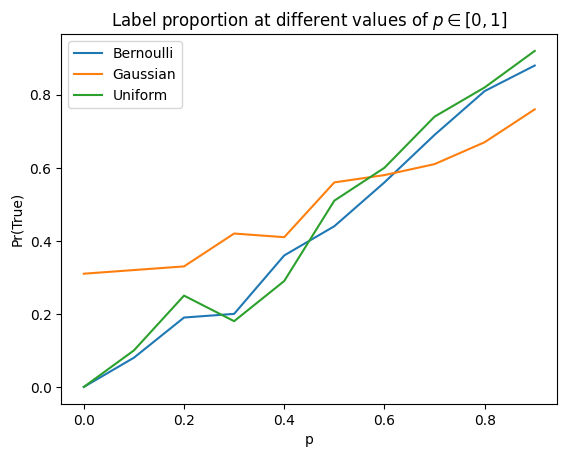

In [61]:
import matplotlib.pyplot as plt
plt.plot(p_vals, b_vals)
plt.plot(p_vals, g_vals)
plt.plot(p_vals, u_vals)
plt.xlabel('p')
plt.ylabel('Pr(True)')
plt.title('Label proportion at different values of $p\in[0,1]$')
plt.legend(['Bernoulli','Gaussian','Uniform'], loc='upper left')
plt.show()

### Question 2
We load the iris data set and change the majority class Setosa with y value 0 to True, and the rest to False. Note: All three classes are equal in number, the majority class is 1/3 of the total data set.

In [62]:
# Load the IRIS dataset
iris = load_iris()
X = iris.data
y = iris.target

# Convert the 3-class target into binary
# Majority class is class 0 (Setosa), assign True (1), others as False (0)
y_binary = np.where(y == 0, True, False)
print(compute_prior(y_binary))

{np.True_: 0.3333333333333333, np.False_: 0.6666666666666666}


In [63]:
precisions, recalls, f1_scores = [], [], []
tpr_vals, fpr_vals = [], []
b_vals = []

In [64]:
for p in p_vals:
    # spawn the sporadic classifier with bernouli random sample generator
    cla = DummyBinaryClassifier(p=p, method='bernoulli')
    # predict the labels for the input
    y = cla.predict(X)
    # compute priors
    props = compute_prior(y)
    # pick the probabilty of True class
    b_vals.append(props[True])

    # Compute Precision, Recall, F1 Score
    precision = precision_score(y_binary, y, zero_division=0)
    recall = recall_score(y_binary, y, zero_division=0)
    f1 = f1_score(y_binary, y, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # fpr, tpr, _ = roc_curve(y_binary, y)
    # tpr_vals.append(tpr)
    # fpr_vals.append(fpr)
    tn, fp, fn, tp = confusion_matrix(y_binary, y).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    tpr_vals.append(tpr)
    fpr_vals.append(fpr)


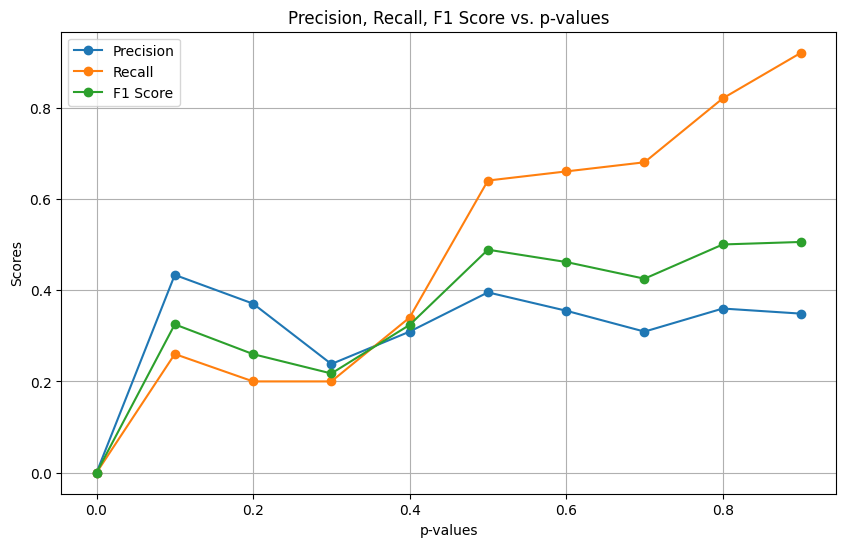

In [65]:
# Plot Precision, Recall, F1 Score for different p-values
plt.figure(figsize=(10, 6))
plt.plot(p_vals, precisions, label='Precision', marker='o')
plt.plot(p_vals, recalls, label='Recall', marker='o')
plt.plot(p_vals, f1_scores, label='F1 Score', marker='o')
plt.xlabel('p-values')
plt.ylabel('Scores')
plt.title('Precision, Recall, F1 Score vs. p-values')
plt.legend()
plt.grid(True)
plt.show()

we notice that the precision tends to 0.3 as the p value goes to 1, as t p=1 we predict every entry as True, and 1/3 of the data points are given as true.
Recal tends to 1 as p tends to 1, as every True data point is also predicted as True.

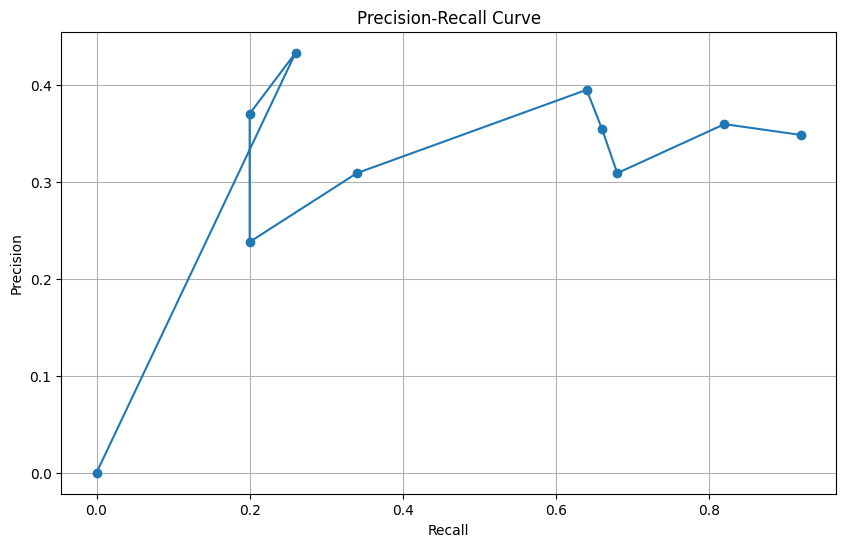

In [66]:
# Plot Precision-Recall Curve (PRC)
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='PRC', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

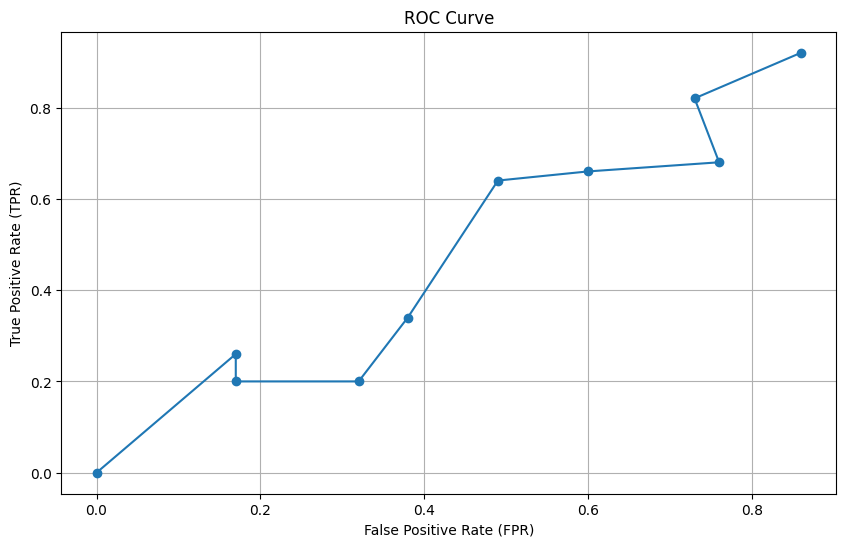

In [67]:
# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_vals, tpr_vals, label='ROC', marker='o')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [68]:
# (They should already be sorted from the curve functions, but sorting again ensures safety)
recalls_sorted, precisions_sorted = zip(*sorted(zip(recalls, precisions)))
fpr_sorted, tpr_sorted = zip(*sorted(zip(fpr_vals, tpr_vals)))

# Compute AUPRC and AURoC
auprc = auc(recalls_sorted, precisions_sorted)  # AUPRC calculation
auroc = auc(fpr_sorted, tpr_sorted) # AURoC calculation

print(f"AUPRC: {auprc:.2f}")
print(f"AURoC: {auroc:.2f}")

AUPRC: 0.28
AURoC: 0.39


The AUPRC and AURoC values

### Question 3
To visualise Fisher's IRIS data we need to project it onto a 2D space as it is originally in 4D (has 4 features) which can't be visualised as such.

In [69]:
# Reduce the dataset to 2D using PCA (for visualization purposes)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Generate a grid of points covering the feature space
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

### with Bernoulli distirbution

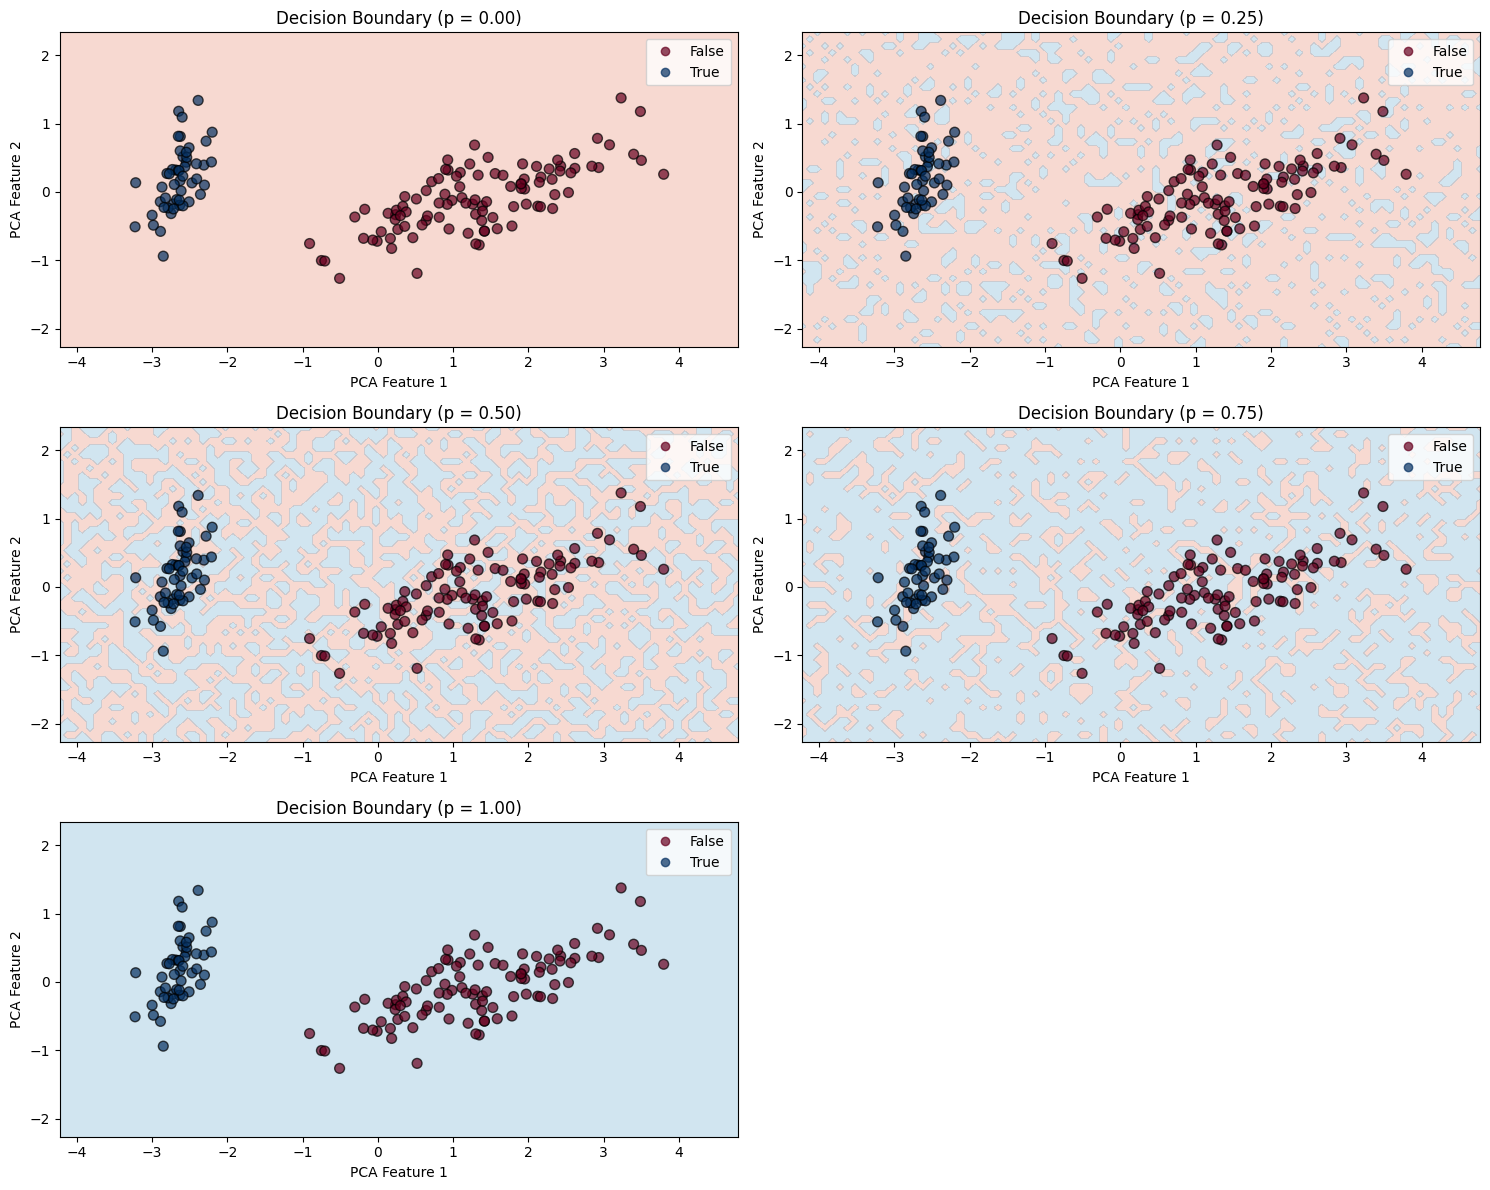

In [70]:
p_vals = np.arange(0, 1.01, 0.25)
plt.figure(figsize=(15, 12))

i=0
for p in p_vals:
    # spawn the sporadic classifier with bernouli random sample generator
    cla = DummyBinaryClassifier(p=p, method='bernoulli')
    # predict the labels for the input
    y = cla.predict(np.c_[xx.ravel(), yy.ravel()])
    y = y.reshape(xx.shape)

    # ax = axes[i]
    # Plot the decision boundary
    plt.subplot(3, 2, i + 1)
    contour=plt.contourf(xx, yy, y, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Scatter plot of the original data points
    scatter=plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_binary, edgecolor='k', s=50, cmap=plt.cm.RdBu, alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=['False', 'True'], loc='upper right')

    
    plt.title(f'Decision Boundary (p = {p:.2f})')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    i+=1

plt.tight_layout()
plt.show()

### with gaussian distirbution

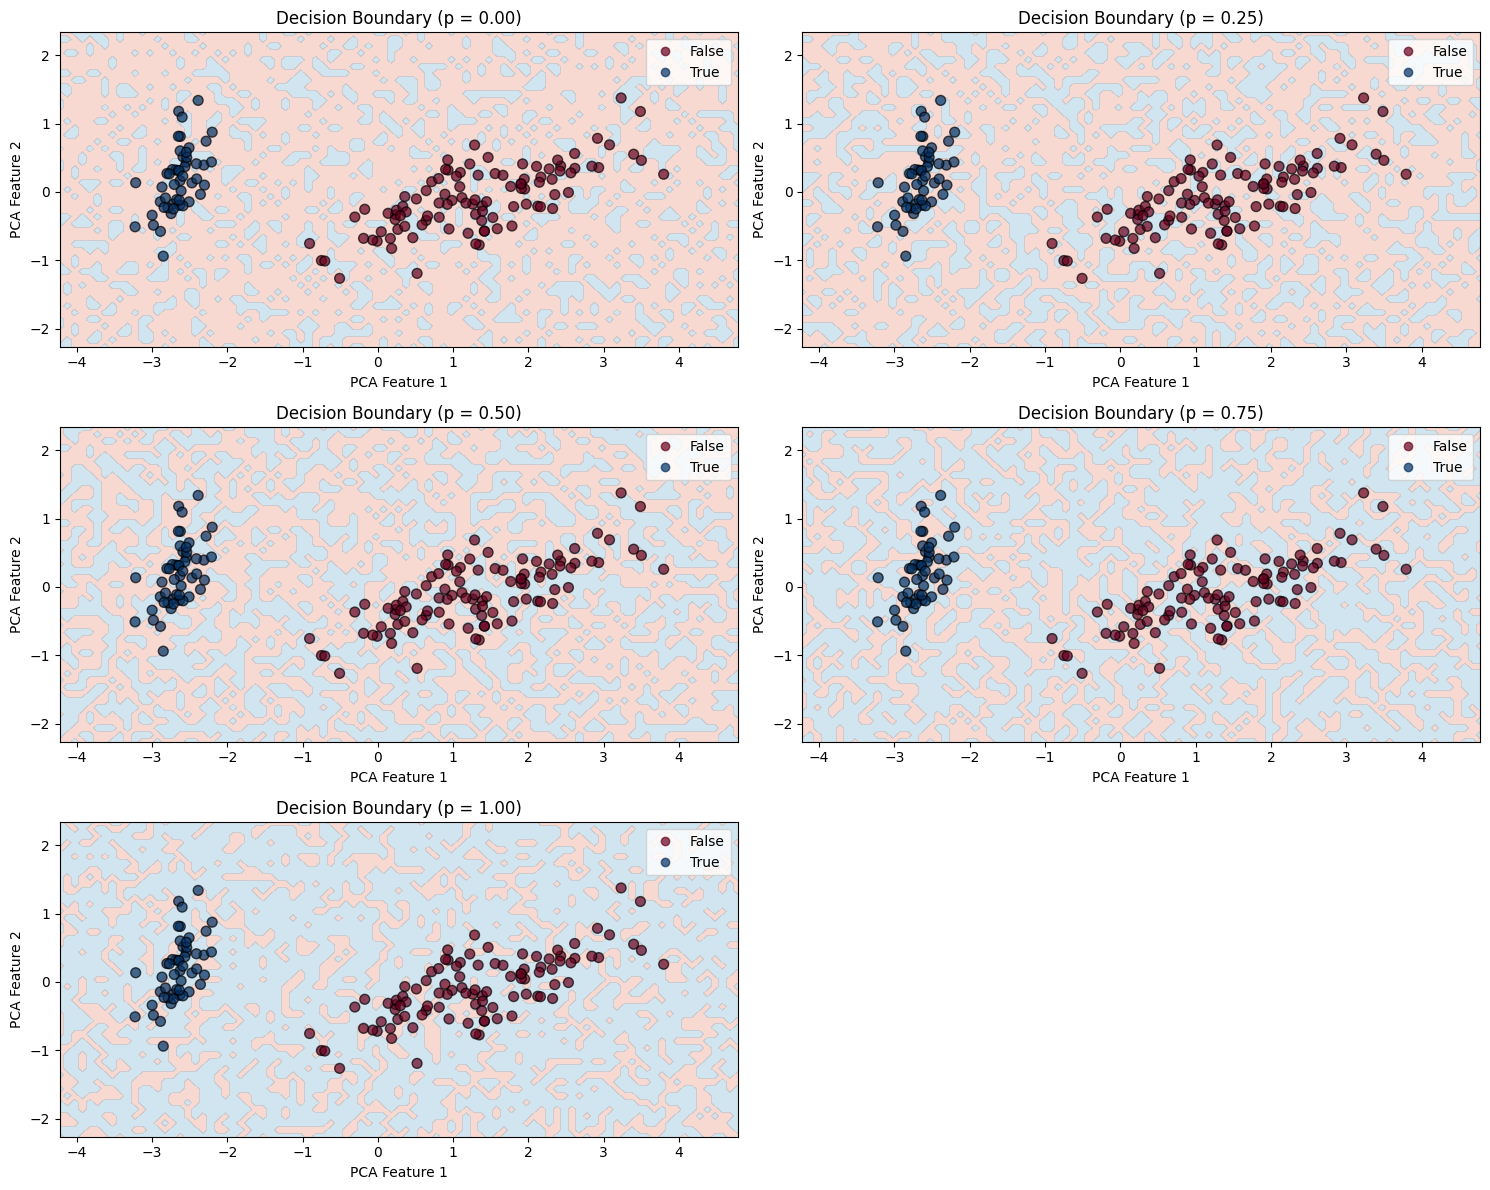

In [71]:
p_vals = np.arange(0, 1.1, 0.25)
plt.figure(figsize=(15, 12))
i=0
for p in p_vals:
    # spawn the sporadic classifier with bernouli random sample generator
    cla = DummyBinaryClassifier(p=p, method='gaussian')
    # predict the labels for the input
    y = cla.predict(np.c_[xx.ravel(), yy.ravel()])
    y = y.reshape(xx.shape)

    # Plot the decision boundary
    plt.subplot(3, 2, i + 1)
    i+=1
    plt.contourf(xx, yy, y, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Scatter plot of the original data points
    scatter=plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_binary, edgecolor='k', s=50, cmap=plt.cm.RdBu, alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=['False', 'True'], loc='upper right')

    
    plt.title(f'Decision Boundary (p = {p:.2f})')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='False', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='True', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], color='black', label='Decision Boundary', lw=2)
]

plt.tight_layout()
plt.show()

### with Uniform distirbution

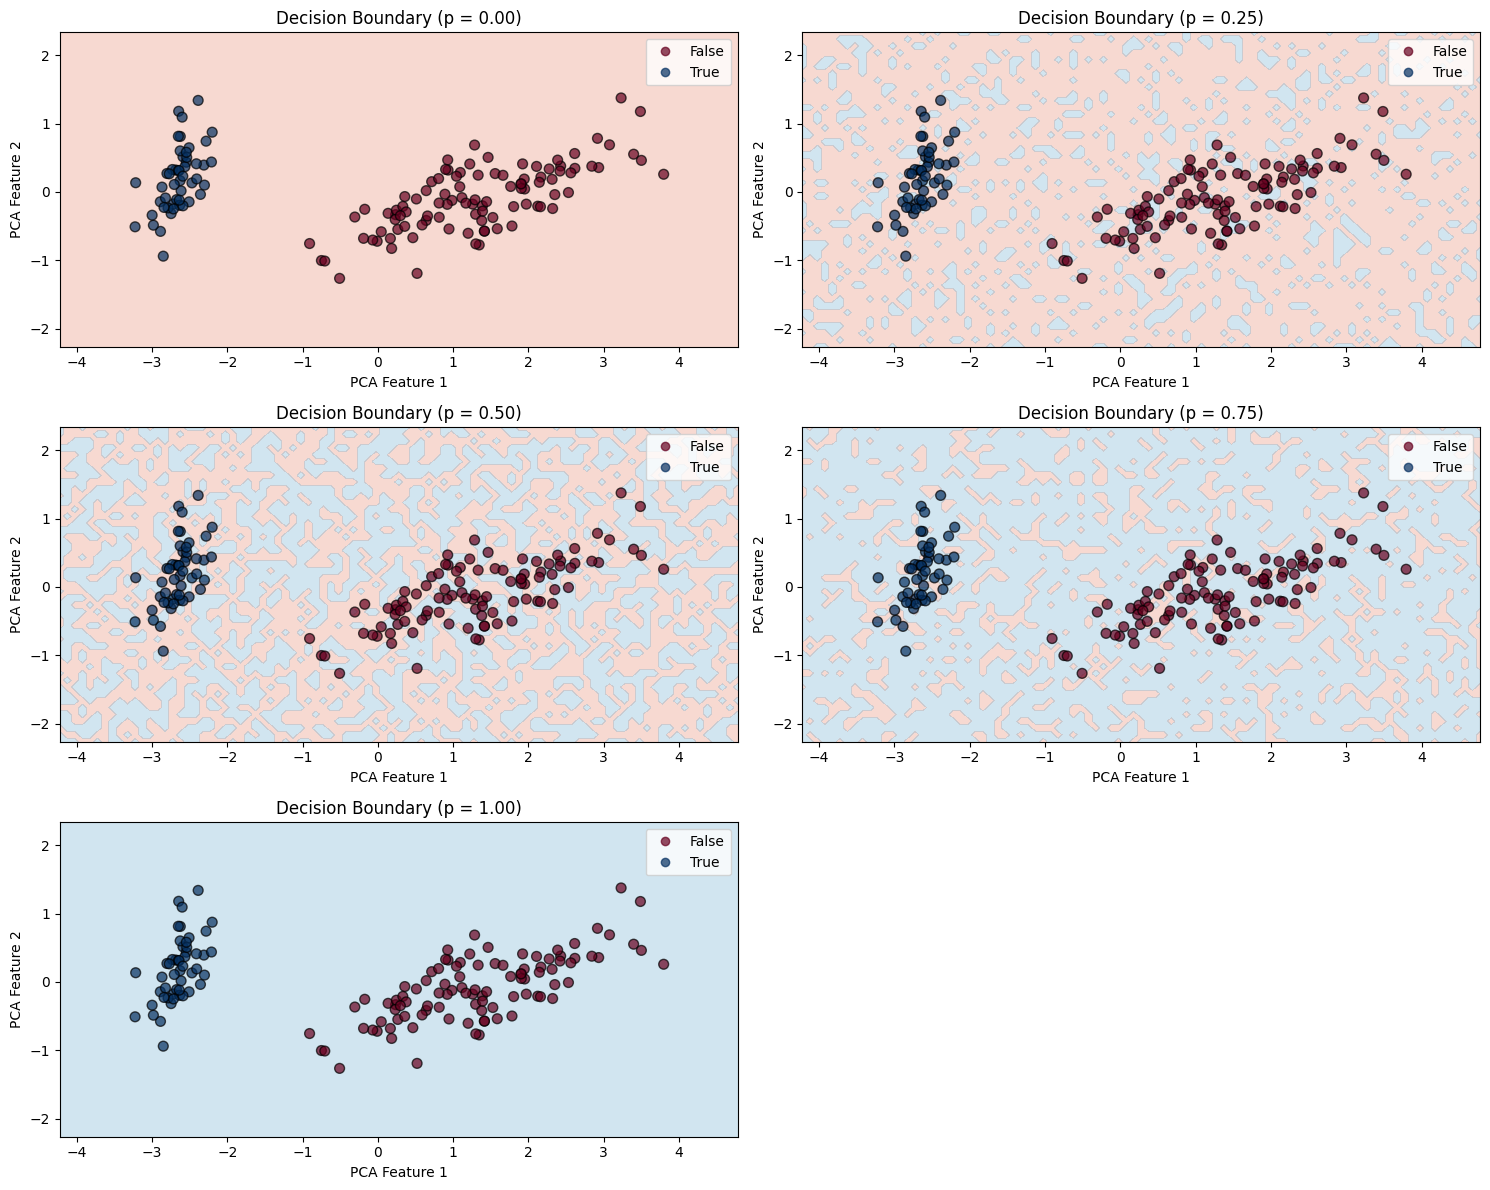

In [72]:
p_vals = np.arange(0, 1.1, 0.25)
plt.figure(figsize=(15, 12))
i=0
for p in p_vals:
    # spawn the sporadic classifier with bernouli random sample generator
    cla = DummyBinaryClassifier(p=p, method='uniform_rand')
    # predict the labels for the input
    y = cla.predict(np.c_[xx.ravel(), yy.ravel()])
    y = y.reshape(xx.shape)

    # Plot the decision boundary
    plt.subplot(3, 2, i + 1)
    i+=1
    plt.contourf(xx, yy, y, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Scatter plot of the original data points
    scatter=plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_binary, edgecolor='k', s=50, cmap=plt.cm.RdBu, alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=['False', 'True'], loc='upper right')

    plt.title(f'Decision Boundary (p = {p:.2f})')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')

# Add a legend for True/False labels
plt.tight_layout()
plt.show()